In [68]:
import time
start = time.time()

import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import astropy.units as u
import os
from itertools import combinations
import emcee
from emcee.utils import MPIPool

from toolkit import (get_phoenix_model_spectrum, EchelleSpectrum, ModelGrid,
                     slice_spectrum, concatenate_spectra, bands_TiO, instr_model, 
                     combine_spectra)
from scipy.signal import gaussian

model_grid = ModelGrid()
fixed_temp_phot = 4780
fixed_temp_spot = fixed_temp_phot - 300
model_phot = model_grid.spectrum(fixed_temp_phot)
model_spot = model_grid.spectrum(fixed_temp_spot)


fits_files = []
#home_dir = '/usr/lusers/bmmorris/freckles_data/'
home_dir = '/local/tmp/freckles/data/'


#for dirpath, dirnames, files in os.walk('/local/tmp/freckles/data/'):
for dirpath, dirnames, files in os.walk(home_dir):
    for file in files:
        file_path = os.path.join(dirpath, file)
        if (file_path.endswith('.fits') and ('weird' not in file_path) 
             and ('dark' not in file_path) and ('HAT' in file_path)):
            fits_files.append(file_path)

fits_files = fits_files[1:]

new_paths = []
for path in fits_files: 
    split_name = path.split(os.sep)
    date = split_name[-2]
    fname = split_name[-1].split('.')
    new_paths.append('fits/' + '.'.join([date] + fname[:2]) + '.npy')
    
def plot_spliced_spectrum(observed_spectrum, model_flux, other_model=None):
    n_chunks = len(slices.wavelength_splits)
    fig, ax = plt.subplots(n_chunks, 1, figsize=(8, 10))

    for i, inds in enumerate(observed_spectrum.wavelength_splits):
        min_ind, max_ind = inds

        ax[i].errorbar(observed_spectrum.wavelength[min_ind:max_ind].value, 
                       observed_spectrum.flux[min_ind:max_ind], 
                       0.025*np.ones(max_ind-min_ind))
        ax[i].plot(observed_spectrum.wavelength[min_ind:max_ind], 
                   model_flux[min_ind:max_ind])
        
        if other_model is not None:
            ax[i].plot(observed_spectrum.wavelength[min_ind:max_ind], 
                       other_model[min_ind:max_ind], alpha=0.4)
        
        ax[i].set_xlim([observed_spectrum.wavelength[max_ind-1].value, 
                        observed_spectrum.wavelength[min_ind].value])
        ax[i].set_ylim([0.9*observed_spectrum.flux[min_ind:max_ind].min(), 
                        1.1])

    return fig, ax

def nearest_order(spectrum, wavelength):
    return np.argmin([abs(spec.wavelength.mean() - wavelength).value
                      for spec in spectrum.spectrum_list])

def nearest_order(spectrum, wavelength):
    return np.argmin([abs(spec.wavelength.mean() - wavelength).value
                      for spec in spectrum.spectrum_list])

#home_dir = '/local/tmp/freckles/' if os.uname().sysname == 'Linux' else os.path.expanduser('~')
standard_path = os.path.join(home_dir, 'Q3UW04/UT160706/BD28_4211.0034.wfrmcpc.fits')
#standard_path = os.path.join(home_dir, 'data/Q3UW04/UT160706/BD28_4211.0034.wfrmcpc.fits')

standard_spectrum = EchelleSpectrum.from_fits(standard_path)

from corner import corner
from astropy.io import ascii

for file_index in range(0, 20):
    #file_index = 2#1#0 #sys.argv[1]
    in_path = fits_files[int(file_index)]
    #in_path = os.path.join('/run/media/bmmorris/PASSPORT/APO/Q3UW04/UT160703',
    #                       'KIC9652680.0028.wfrmcpc.fits')
                            #'KIC9652680.0025.wfrmcpc.fits')#fits_files[-2]
    print(in_path)
    target_spectrum = EchelleSpectrum.from_fits(in_path)
    only_orders = list(range(len(target_spectrum.spectrum_list)))
    target_spectrum.continuum_normalize(standard_spectrum,
                                        polynomial_order=10,
                                        only_orders=only_orders,
                                        plot_masking=False)

    rv_shifts = u.Quantity([target_spectrum.rv_wavelength_shift(order, T_eff=5618)
                            for order in only_orders])
    median_rv_shift = np.median(rv_shifts)

    target_spectrum.offset_wavelength_solution(median_rv_shift)

    spec_band = []
    for band in bands_TiO:
        band_order = target_spectrum.get_order(nearest_order(target_spectrum, band.core))
        target_slice = slice_spectrum(band_order, band.min, band.max)
        target_slice.flux /= target_slice.flux.max()
        spec_band.append(target_slice)
    slices = concatenate_spectra(spec_band)

    def instr_model_fixed(spotted_area, lam_offset, res, observed_spectrum):

        kernel = gaussian(int(5*res), res)
        combined_spectrum = combine_spectra(model_phot, model_spot, spotted_area)
        combined_spectrum.convolve(kernel=kernel)

        # Apply wavelength correction just to red wavelengths:
        corrected_wavelengths = observed_spectrum.wavelength.copy()
        mid_wavelengths = ((corrected_wavelengths > 7000*u.Angstrom) & 
                           (corrected_wavelengths < 8500*u.Angstrom))
        blue_wavelengths = (corrected_wavelengths < 7000*u.Angstrom)
        red_wavelengths = corrected_wavelengths > 8500*u.Angstrom
        corrected_wavelengths[mid_wavelengths] -= lam_offset*u.Angstrom
        corrected_wavelengths[blue_wavelengths] -= (lam_offset + 0.35)*u.Angstrom
        corrected_wavelengths[red_wavelengths] -= (lam_offset - 0.35)*u.Angstrom

        combined_interp = combined_spectrum.interpolate(corrected_wavelengths)

        A = np.vstack([combined_interp, corrected_wavelengths.value]).T

        combined_scaled = combined_interp.copy()
        residuals = 0
        for i_min, i_max in observed_spectrum.wavelength_splits:

            c, residuals_i = np.linalg.lstsq(A[i_min:i_max, :], 
                                             observed_spectrum.flux[i_min:i_max, np.newaxis])[0:2]

            residuals += residuals_i
            #combined_scaled[i_min:i_max] = c[0] * combined_interp[i_min:i_max] 
            combined_scaled[i_min:i_max] = (c[0] * combined_interp[i_min:i_max] + 
                                            c[1] * corrected_wavelengths[i_min:i_max].value)

        return combined_scaled, residuals


    samples = np.loadtxt('/local/tmp/freckles/outputs/chains_{0:02d}.txt'
                         .format(file_index)) #sampler.flatchain[400:, :]

    corner(samples, labels=['$\log a$', '$\Delta \lambda$', '$\log f$', '$\sigma$']);
    plt.savefig('plot_results/corner_{0:02d}.png'.format(file_index), bbox_inches='tight', dpi=150)
    plt.close()


    best_lna, best_dlam, best_lnf, best_res = np.median(samples, axis=0)
    best_area = np.exp(best_lna)
    
    tio_table = ascii.read('data/valenti1998.txt')
    min_rank, max_rank = 1, tio_table['rank'].max()

    tio_wavelengths = tio_table['wavelength']
    tio_strengths = 1 - (tio_table['rank']-min_rank)/(max_rank-min_rank)

    observed_spectrum = slices
    #model_flux = best_model

    n_random_draws = 100

    n_chunks = len(slices.wavelength_splits)
    fig, ax = plt.subplots(n_chunks, 1, figsize=(8, 10))

    for i, inds in enumerate(observed_spectrum.wavelength_splits):
        min_ind, max_ind = inds

        ax[i].errorbar(observed_spectrum.wavelength[min_ind:max_ind].value, 
                       observed_spectrum.flux[min_ind:max_ind], 
                       np.exp(best_lnf) * observed_spectrum.flux[min_ind:max_ind], 
                       fmt='o', color='k')
                       #0.025*np.ones(max_ind-min_ind), fmt='.')
        #ax[i].plot(observed_spectrum.wavelength[min_ind:max_ind], 
        #           best_model[min_ind:max_ind], color='r')

        ax[i].set_xlim([observed_spectrum.wavelength[max_ind-1].value, 
                        observed_spectrum.wavelength[min_ind].value])
        ax[i].set_ylim([0.9*observed_spectrum.flux[min_ind:max_ind].min(), 
                        1.1])

        for tiowl, tior in zip(tio_wavelengths, tio_strengths):
            ax[i].axvline(tiowl, alpha=tior)

    # draw models from posteriors
    for j in range(n_random_draws):
        step = np.random.randint(0, samples.shape[0])
        random_step = samples[step, :]#sampler.flatchain[step, :]
        rand_area, rand_dlam, rand_lnf, rand_res = np.exp(random_step[0]), random_step[1], random_step[2], random_step[3]

        rand_model = instr_model_fixed(rand_area, rand_dlam, rand_res, slices)[0]

        for i, inds in enumerate(observed_spectrum.wavelength_splits):
            min_ind, max_ind = inds
            ax[i].plot(observed_spectrum.wavelength[min_ind:max_ind], 
                       rand_model[min_ind:max_ind], color='#389df7', alpha=0.05)

    # annotate lines
    #for i, inds in enumerate(observed_spectrum.wavelength_splits):
    notes_kwargs = dict(ha='center', va='center')
    ax[0].annotate("Fe I", xy=(5600.0, 1), **notes_kwargs)
    ax[3].annotate("Fe II", xy=(7127.421, 1), **notes_kwargs)
    
    fig.savefig('plot_results/spectrum_{0:02d}.png'.format(file_index), bbox_inches='tight', dpi=200)
    plt.close()

/local/tmp/freckles/data/Q3UW04/UT160706/HAT-P-11.0036.wfrmcpc.fits
/local/tmp/freckles/data/Q3UW04/UT160707/HAT-P-11.0034.wfrmcpc.fits
/local/tmp/freckles/data/Q3UW04/UT160707/HAT-P-11.0035.wfrmcpc.fits
/local/tmp/freckles/data/Q3UW04/UT160707/HAT-P-11.0036.wfrmcpc.fits
/local/tmp/freckles/data/Q3UW04/UT160709/HAT-P-11.0011.wfrmcpc.fits
/local/tmp/freckles/data/Q3UW04/UT170411/HAT-P-11.0026.wfrmcpc.fits
/local/tmp/freckles/data/Q3UW04/UT170411/HAT-P-11.0027.wfrmcpc.fits
/local/tmp/freckles/data/Q3UW04/UT170411/HAT-P-11.0028.wfrmcpc.fits


/local/tmp/freckles/data/Q3UW04/UT170411/HAT-P-11.0029.wfrmcpc.fits
/local/tmp/freckles/data/Q3UW04/UT170411/HAT-P-11.0030.wfrmcpc.fits


/local/tmp/freckles/data/Q3UW04/UT170411/HAT-P-11.0031.wfrmcpc.fits


/local/tmp/freckles/data/Q3UW04/UT170411/HAT-P-11.0032.wfrmcpc.fits
/local/tmp/freckles/data/Q3UW04/UT170411/HAT-P-11.0033.wfrmcpc.fits
/local/tmp/freckles/data/Q3UW04/UT170612/HAT-P-11.0001.wfrmcpc.fits
/local/tmp/freckles/data/Q3UW04/UT170612/HAT-P-11.0002.wfrmcpc.fits


/local/tmp/freckles/data/Q3UW04/UT170612/HAT-P-11.0009.wfrmcpc.fits
/local/tmp/freckles/data/Q3UW04/UT170612/HAT-P-11.0010.wfrmcpc.fits
/local/tmp/freckles/data/Q3UW04/UT170612/HAT-P-11.0011.wfrmcpc.fits
/local/tmp/freckles/data/Q3UW04/UT170620/HAT-P-11.0072.wfrmcpc.fits


/local/tmp/freckles/data/Q3UW04/UT170620/HAT-P-11.0073.wfrmcpc.fits


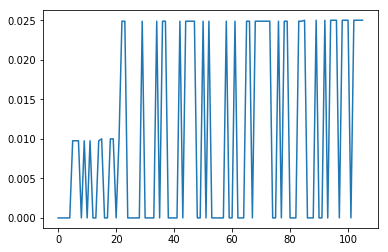

In [62]:
from astropy.stats import sigma_clip, mad_std, sigma_clipping
clipped = sigma_clip(rv_shifts.value, iters=2).mask
rv_shifts_clipped = rv_shifts.value[~clipped]
plt.plot(rv_shifts_clipped)
x = np.arange(len(rv_shifts_clipped))
y = np.polyval(np.polyfit(x, rv_shifts_clipped, 1), x)
# plt.plot(y)
# plt.ylim([y.min(), y.max()])

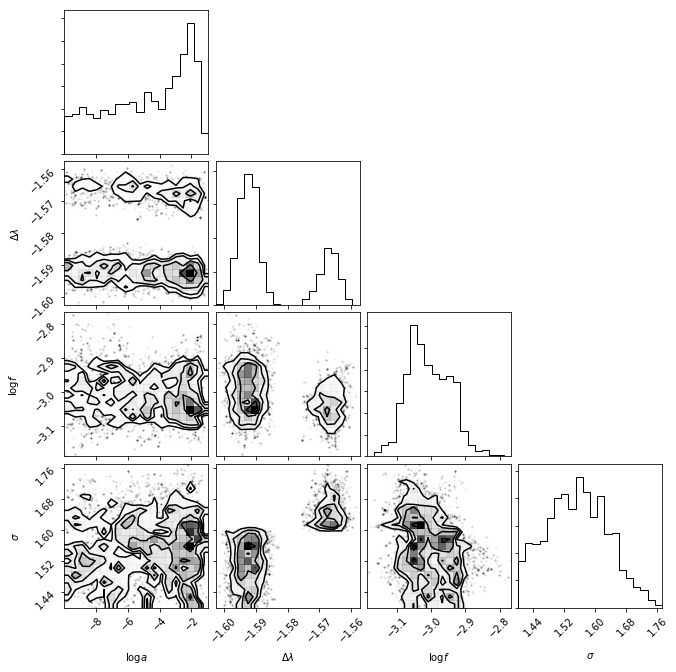

In [63]:
%matplotlib inline
from corner import corner

samples = np.loadtxt('/local/tmp/freckles/outputs/chains_{0:02d}.txt'
                     .format(file_index)) #sampler.flatchain[400:, :]

corner(samples, labels=['$\log a$', '$\Delta \lambda$', '$\log f$', '$\sigma$']);

#plt.figure()
#plt.plot(sampler.lnprobability[:, 500:].T)

In [64]:
best_lna, best_dlam, best_lnf, best_res = np.median(samples, axis=0)
best_area = np.exp(best_lna)

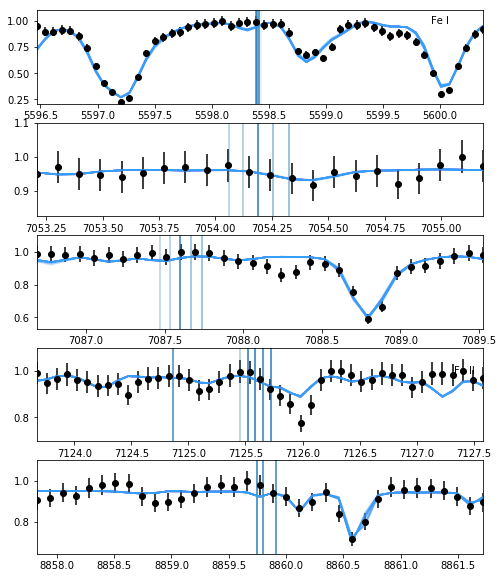

In [65]:
from astropy.io import ascii

tio_table = ascii.read('data/valenti1998.txt')
min_rank, max_rank = 1, tio_table['rank'].max()

tio_wavelengths = tio_table['wavelength']
tio_strengths = 1 - (tio_table['rank']-min_rank)/(max_rank-min_rank)

observed_spectrum = slices
#model_flux = best_model

n_random_draws = 100

n_chunks = len(slices.wavelength_splits)
fig, ax = plt.subplots(n_chunks, 1, figsize=(8, 10))

for i, inds in enumerate(observed_spectrum.wavelength_splits):
    min_ind, max_ind = inds

    ax[i].errorbar(observed_spectrum.wavelength[min_ind:max_ind].value, 
                   observed_spectrum.flux[min_ind:max_ind], 
                   np.exp(best_lnf) * observed_spectrum.flux[min_ind:max_ind], 
                   fmt='o', color='k')
                   #0.025*np.ones(max_ind-min_ind), fmt='.')
    #ax[i].plot(observed_spectrum.wavelength[min_ind:max_ind], 
    #           best_model[min_ind:max_ind], color='r')

    ax[i].set_xlim([observed_spectrum.wavelength[max_ind-1].value, 
                    observed_spectrum.wavelength[min_ind].value])
    ax[i].set_ylim([0.9*observed_spectrum.flux[min_ind:max_ind].min(), 
                    1.1])

    for tiowl, tior in zip(tio_wavelengths, tio_strengths):
        ax[i].axvline(tiowl, alpha=tior)
        
# draw models from posteriors
for j in range(n_random_draws):
    step = np.random.randint(0, samples.shape[0])
    random_step = samples[step, :]#sampler.flatchain[step, :]
    rand_area, rand_dlam, rand_lnf, rand_res = np.exp(random_step[0]), random_step[1], random_step[2], random_step[3]

    rand_model = instr_model_fixed(rand_area, rand_dlam, rand_res, slices)[0]

    for i, inds in enumerate(observed_spectrum.wavelength_splits):
        min_ind, max_ind = inds
        ax[i].plot(observed_spectrum.wavelength[min_ind:max_ind], 
                   rand_model[min_ind:max_ind], color='#389df7', alpha=0.05)

# annotate lines
#for i, inds in enumerate(observed_spectrum.wavelength_splits):
notes_kwargs = dict(ha='center', va='center')
ax[0].annotate("Fe I", xy=(5600.0, 1), **notes_kwargs)
ax[3].annotate("Fe II", xy=(7127.421, 1), **notes_kwargs)

(array([  939.,   773.,   623.,   624.,   583.,   439.,   616.,  1324.,
         2614.,  1465.]),
 array([-9.99242766, -9.0838464 , -8.17526515, -7.26668389, -6.35810263,
        -5.44952137, -4.54094012, -3.63235886, -2.7237776 , -1.81519635,
        -0.90661509]),
 <a list of 10 Patch objects>)

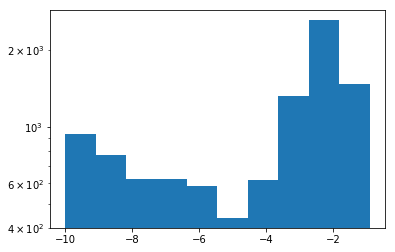

In [21]:
plt.hist(samples[:, 0], log=True)